100%|██████████| 9.91M/9.91M [00:00<00:00, 42.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.20MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 10.7MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.45MB/s]


Dataset saved to rotated_mnist.npz with 152400 samples.


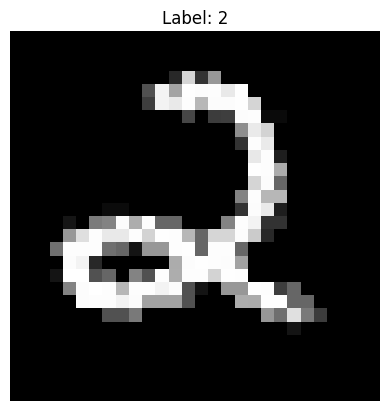

In [ ]:
# Part 1 creating the dataset of raotated mnist
import os
import numpy as np
import torch
import random
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torchvision.transforms.functional import rotate
from PIL import Image

# Define parameters
rotation_angles = [30 * i for i in range(12)]  # 0 to 330 degrees
save_path = "rotated_mnist.npz"
selected_digits = {1, 2}  # Use only digits 1 and 2

# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor()
])
mnist_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)

# Filter for digits 1 and 2
dataset_filtered = [(image, label) for image, label in mnist_dataset if label in selected_digits]

# Function to rotate images
def rotate_dataset(dataset, angles):
    rotated_dataset = []
    for image, label in dataset:
        for angle in angles:
            rotated_image = rotate(image, angle)
            rotated_dataset.append((rotated_image, label))
    return rotated_dataset

# Apply rotations
rotated_dataset = rotate_dataset(dataset_filtered, rotation_angles)

# Shuffle dataset
random.shuffle(rotated_dataset)

# Convert dataset to numpy arrays
images, labels = zip(*rotated_dataset)
images = np.array([img.numpy() for img in images])
labels = np.array(labels)

# Save dataset
np.savez_compressed(save_path, images=images, labels=labels)
print(f"Dataset saved to {save_path} with {len(images)} samples.")

# Display example image
example_image, example_label = rotated_dataset[0]
plt.imshow(example_image.squeeze(), cmap='gray')
plt.title(f"Label: {example_label}")
plt.axis('off')
plt.show()


152400
Epoch 1, Loss: 40.1859
Epoch 2, Loss: 35.4195
Epoch 3, Loss: 33.8267
Epoch 4, Loss: 33.0715
Epoch 5, Loss: 32.6454
Epoch 6, Loss: 32.3865
Epoch 7, Loss: 32.2292
Epoch 8, Loss: 32.1184
Epoch 9, Loss: 31.9813
Epoch 10, Loss: 31.9281
Training complete!


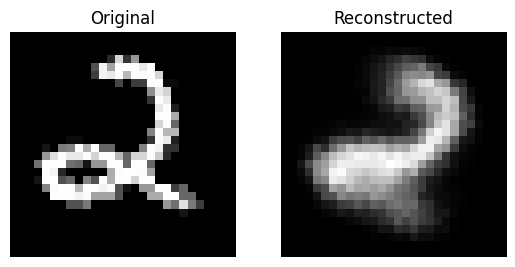

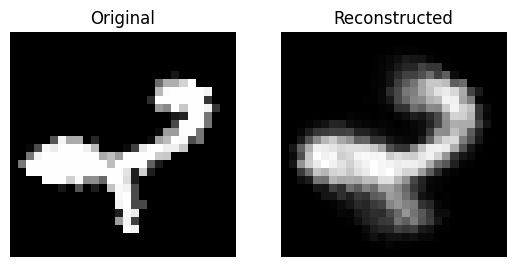

In [ ]:
#Part 2 - The VAE is trained below on the created dataset

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

# Load the rotated MNIST dataset
npzfile = np.load("rotated_mnist.npz")
images, labels = npzfile["images"], npzfile["labels"]

print(len(images))
# Using only 20000 images due to compute issues
images = images[:20000]
labels = labels[:20000]

# Normalize images
images = torch.tensor(images, dtype=torch.float32)
labels = torch.tensor(labels, dtype=torch.long)
dataset = TensorDataset(images, labels)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

# Define the VAE model
class VAE(nn.Module):
    def __init__(self, latent_dim=16):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU()
        )

        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_logvar = nn.Linear(128, latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 28*28),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        encoded = self.encoder(x)
        mu, logvar = self.fc_mu(encoded), self.fc_logvar(encoded)
        z = self.reparameterize(mu, logvar)
        decoded = self.decoder(z)
        return decoded, mu, logvar

# Define loss function
def vae_loss(reconstructed, original, mu, logvar):
    recon_loss = nn.functional.mse_loss(reconstructed, original.view(-1, 28*28), reduction='sum')
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_div

# Initialize model, optimizer
latent_dim = 16
vae = VAE(latent_dim=latent_dim)
optimizer = optim.Adam(vae.parameters(), lr=0.001)

# Training loop
num_epochs = 10
vae.train()
for epoch in range(num_epochs):
    total_loss = 0
    for batch, _ in dataloader:
        batch = batch.view(-1, 28*28)
        optimizer.zero_grad()
        reconstructed, mu, logvar = vae(batch)
        loss = vae_loss(reconstructed, batch, mu, logvar)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(dataset):.4f}")

print("Training complete!")

# Testing VAE on 1-2 images
vae.eval()
with torch.no_grad():
    for i in range(2):
        img = images[i].view(-1, 28*28)
        reconstructed, _, _ = vae(img)
        reconstructed = reconstructed.view(28, 28).numpy()

        # Plot original and reconstructed images
        plt.subplot(1, 2, 1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.title("Original")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(reconstructed, cmap='gray')
        plt.title("Reconstructed")
        plt.axis("off")

        plt.show()


In [ ]:
# Part 2 - MLP trained below on latent space
class MLP(nn.Module):
    def __init__(self, latent_dim):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)
        )

    def forward(self, z):
        return self.model(z)

mlp = MLP(latent_dim)
mlp_optimizer = optim.Adam(mlp.parameters(), lr=0.001)
mlp_loss_fn = nn.MSELoss()

# Prepare dataset of latent space transformations
latent_pairs = []
vae.eval()
with torch.no_grad():
    for img in images:
        img = img.view(1, 1, 28, 28)
        img_flat = img.view(-1, 28*28)
        _, mu, _ = vae(img_flat)
        for angle in range(30, 60, 30):
            rotated_img = rotate(img, angle)
            rotated_img_flat = rotated_img.view(-1, 28*28)
            _, rotated_mu, _ = vae(rotated_img_flat)
            latent_pairs.append((mu.squeeze(0), rotated_mu.squeeze(0)))

# Convert to tensors
latent_x = torch.stack([pair[0] for pair in latent_pairs])
latent_y = torch.stack([pair[1] for pair in latent_pairs])
mlp_dataset = TensorDataset(latent_x, latent_y)
mlp_dataloader = DataLoader(mlp_dataset, batch_size=1, shuffle=True)

# Train MLP
num_epochs = 20
mlp.train()
for epoch in range(num_epochs):
    total_loss = 0
    for x, y in mlp_dataloader:
        mlp_optimizer.zero_grad()
        y_pred = mlp(x)
        loss = mlp_loss_fn(y_pred, y)
        loss.backward()
        mlp_optimizer.step()
        total_loss += loss.item()
    print(f"MLP Epoch {epoch+1}, Loss: {total_loss/len(mlp_dataset):.4f}")

print("MLP Training complete!")


MLP Epoch 1, Loss: 0.0228
MLP Epoch 2, Loss: 0.0145
MLP Epoch 3, Loss: 0.0134
MLP Epoch 4, Loss: 0.0128
MLP Epoch 5, Loss: 0.0124
MLP Epoch 6, Loss: 0.0122
MLP Epoch 7, Loss: 0.0120
MLP Epoch 8, Loss: 0.0118
MLP Epoch 9, Loss: 0.0117
MLP Epoch 10, Loss: 0.0116
MLP Epoch 11, Loss: 0.0115
MLP Epoch 12, Loss: 0.0114
MLP Epoch 13, Loss: 0.0113
MLP Epoch 14, Loss: 0.0112
MLP Epoch 15, Loss: 0.0112
MLP Epoch 16, Loss: 0.0111
MLP Epoch 17, Loss: 0.0110
MLP Epoch 18, Loss: 0.0110
MLP Epoch 19, Loss: 0.0109
MLP Epoch 20, Loss: 0.0110
MLP Training complete!


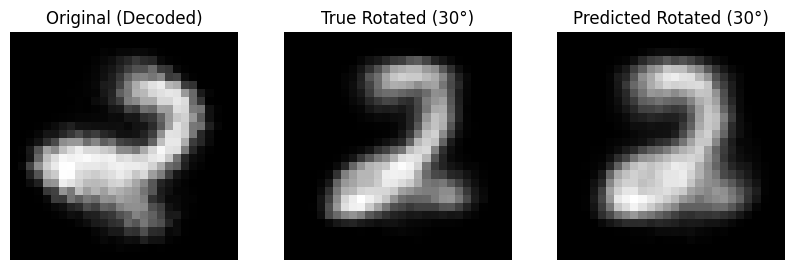

In [ ]:
# Test the MLP and visualize results
vae.eval()
mlp.eval()

def visualize_results(img, angle):
    img = img.view(1, 1, 28, 28)
    img_flat = img.view(-1, 28*28)

    # Get original latent vector
    _, mu, _ = vae(img_flat)

    # Rotate image and get true rotated latent vector
    rotated_img = rotate(img, angle)
    rotated_img_flat = rotated_img.view(-1, 28*28)
    _, rotated_mu, _ = vae(rotated_img_flat)

    # Predict rotated latent vector using MLP
    predicted_rotated_mu = mlp(mu)

    # Decode latent vectors back to image space
    decoded_original = vae.decoder(mu).view(28, 28).detach().numpy()
    decoded_true_rotated = vae.decoder(rotated_mu).view(28, 28).detach().numpy()
    decoded_predicted_rotated = vae.decoder(predicted_rotated_mu).view(28, 28).detach().numpy()

    # Plot the images
    fig, axs = plt.subplots(1, 3, figsize=(10, 4))
    axs[0].imshow(decoded_original, cmap="gray")
    axs[0].set_title("Original (Decoded)")
    axs[0].axis("off")

    axs[1].imshow(decoded_true_rotated, cmap="gray")
    axs[1].set_title(f"True Rotated ({angle}°)")
    axs[1].axis("off")

    axs[2].imshow(decoded_predicted_rotated, cmap="gray")
    axs[2].set_title(f"Predicted Rotated ({angle}°)")
    axs[2].axis("off")

    plt.show()

# Run visualization on a test image with a 30° rotation
test_img = images[900]  # Select an image
visualize_results(test_img, 30)

